In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import math

In [2]:
def regSummary(y_true, y_pred):
    return{
        "r2_score": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": math.sqrt(mean_squared_error(y_true, y_pred))
    }

In [3]:
df = pd.read_csv("../Dataset/housing.csv")

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Imputing the null values

In [4]:
imputer = SimpleImputer()
imputer.set_output(transform="pandas")
df2 = imputer.fit_transform(df.drop(columns="ocean_proximity"))
df2.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [5]:
data_x = df2.drop(columns="median_house_value")
data_y = df2.median_house_value

scaler = StandardScaler()
scaler.set_output(transform="pandas")
data_x = scaler.fit_transform(data_x)

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3)

## Creating a SGD model and learning curve on max_iter

In [12]:
sgd_red = SGDRegressor()

grid_search = GridSearchCV(
    sgd_red,
    param_grid={
        "max_iter":np.arange(100,2000,10),
        "early_stopping" : [False, True]
    },
    verbose=3,
    n_jobs=3
)

In [13]:
grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 380 candidates, totalling 1900 fits


GridSearchCV(estimator=SGDRegressor(), n_jobs=3,
             param_grid={'early_stopping': [False, True],
                         'max_iter': array([ 100,  110,  120,  130,  140,  150,  160,  170,  180,  190,  200,
        210,  220,  230,  240,  250,  260,  270,  280,  290,  300,  310,
        320,  330,  340,  350,  360,  370,  380,  390,  400,  410,  420,
        430,  440,  450,  460,  470,  480,  490,  500,  510,  520,  530,
        540,  550,  560,  570,  580,  590,  600,  610,  620,  630,  640,
        650,  660,  670,  680,  690,  700...
       1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410,
       1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520,
       1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630,
       1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740,
       1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 1850,
       1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960,
       1970, 1980, 1990])},
             verbose=3)

In [14]:
grid_search.best_estimator_

SGDRegressor(early_stopping=True, max_iter=1690)

In [15]:
grid_search.best_score_

0.638624244010928

In [16]:
grid_summary = pd.DataFrame({
    "score" : grid_search.cv_results_["mean_test_score"],
    "max_iter" : grid_search.cv_results_["param_max_iter"],
    "early_stopping" : grid_search.cv_results_["param_early_stopping"],
})

grid_summary.head()

,score,max_iter,early_stopping
0,0.637214,100,False
1,0.636949,110,False
2,0.636333,120,False
3,0.636228,130,False
4,0.635099,140,False


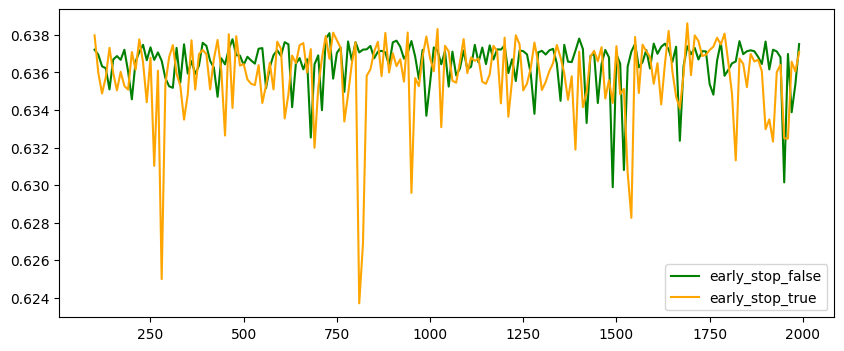

In [17]:
fig, ax = plt.subplots(figsize=(10,4))

early_stop = grid_summary.groupby("early_stopping")

ax.plot(early_stop.get_group(False)["max_iter"], early_stop.get_group(False)["score"], color="green", label="early_stop_false")
ax.plot(early_stop.get_group(True)["max_iter"], early_stop.get_group(True)["score"], color="orange", label="early_stop_true")

plt.legend()
plt.show()

## Tuning the n_iter_no_change

In [18]:
grid_search = GridSearchCV(
    sgd_red,
    param_grid={
        "max_iter":np.arange(100,2000,100),
        "early_stopping" : [False, True],
        "n_iter_no_change" : np.arange(5,50,5)
    },
    verbose=3,
    n_jobs=3
)

In [19]:
grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(estimator=SGDRegressor(), n_jobs=3,
             param_grid={'early_stopping': [False, True],
                         'max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]),
                         'n_iter_no_change': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])},
             verbose=3)

In [21]:
grid_summary = pd.DataFrame({
    "score" : grid_search.cv_results_["mean_test_score"],
    "max_iter" : grid_search.cv_results_["param_max_iter"],
    "early_stopping" : grid_search.cv_results_["param_early_stopping"],
    "n_iter_no_change" : grid_search.cv_results_["param_n_iter_no_change"]
})

grid_summary.head()

,score,max_iter,early_stopping,n_iter_no_change
0,0.636455,100,False,5
1,0.637460,100,False,10
2,0.637698,100,False,15
3,0.636883,100,False,20
4,0.637375,100,False,25


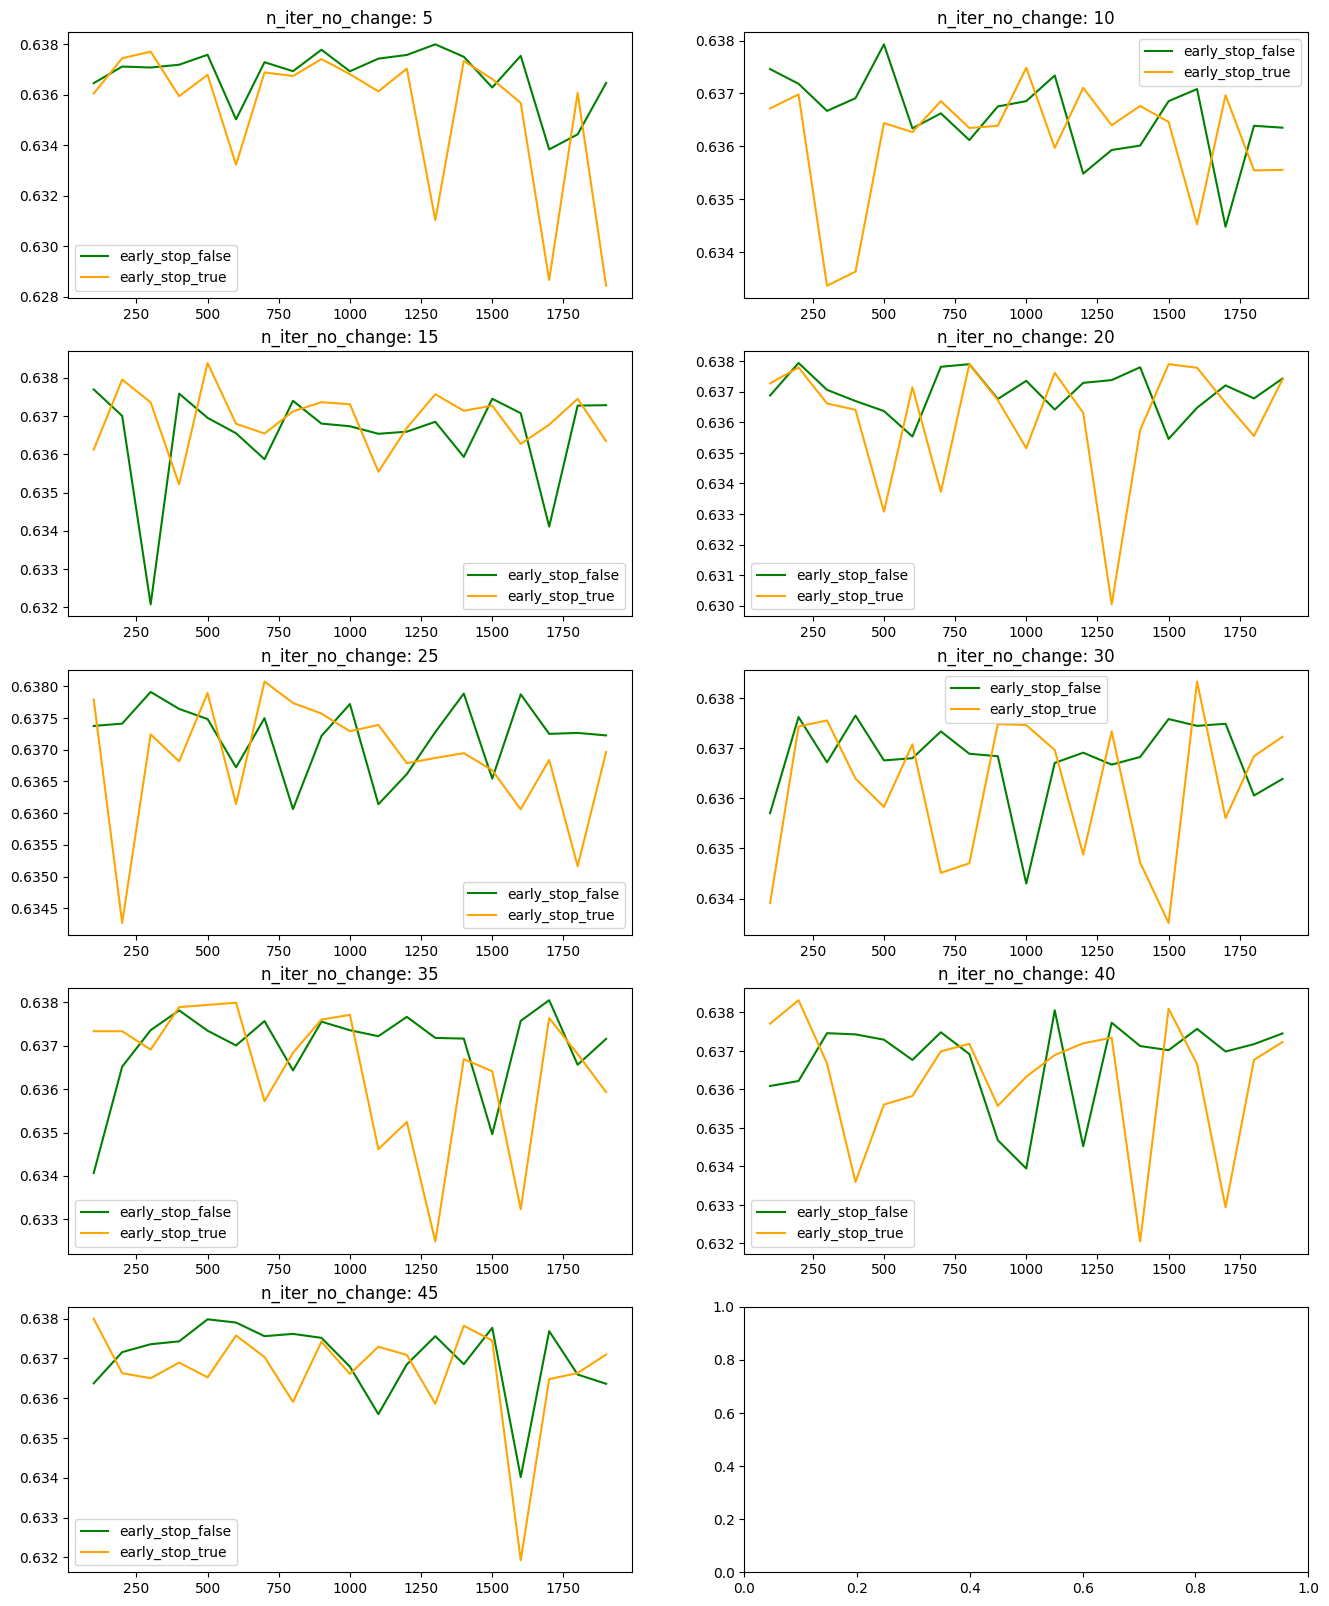

In [27]:
n_groups_set = grid_summary.groupby("n_iter_no_change")

fig, ax = plt.subplots(figsize=(16,2*10), nrows=5, ncols=2)

axes = ax.flat

n_groups = grid_search.get_params()["param_grid"]["n_iter_no_change"]

for group in n_groups:
    groups = n_groups_set.get_group(group)
    early_stop = groups.groupby("early_stopping")
    ax = next(axes)
    ax.set_title(f"n_iter_no_change: {group}")
    ax.plot(early_stop.get_group(False)["max_iter"], early_stop.get_group(False)["score"], color="green", label="early_stop_false")
    ax.plot(early_stop.get_group(True)["max_iter"], early_stop.get_group(True)["score"], color="orange", label="early_stop_true")

    ax.legend()
plt.show()

In [28]:
grid_search.best_estimator_

SGDRegressor(early_stopping=True, max_iter=500, n_iter_no_change=15)

In [29]:
grid_search.best_score_

0.6383904897581095

## Constant Learning Rate

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


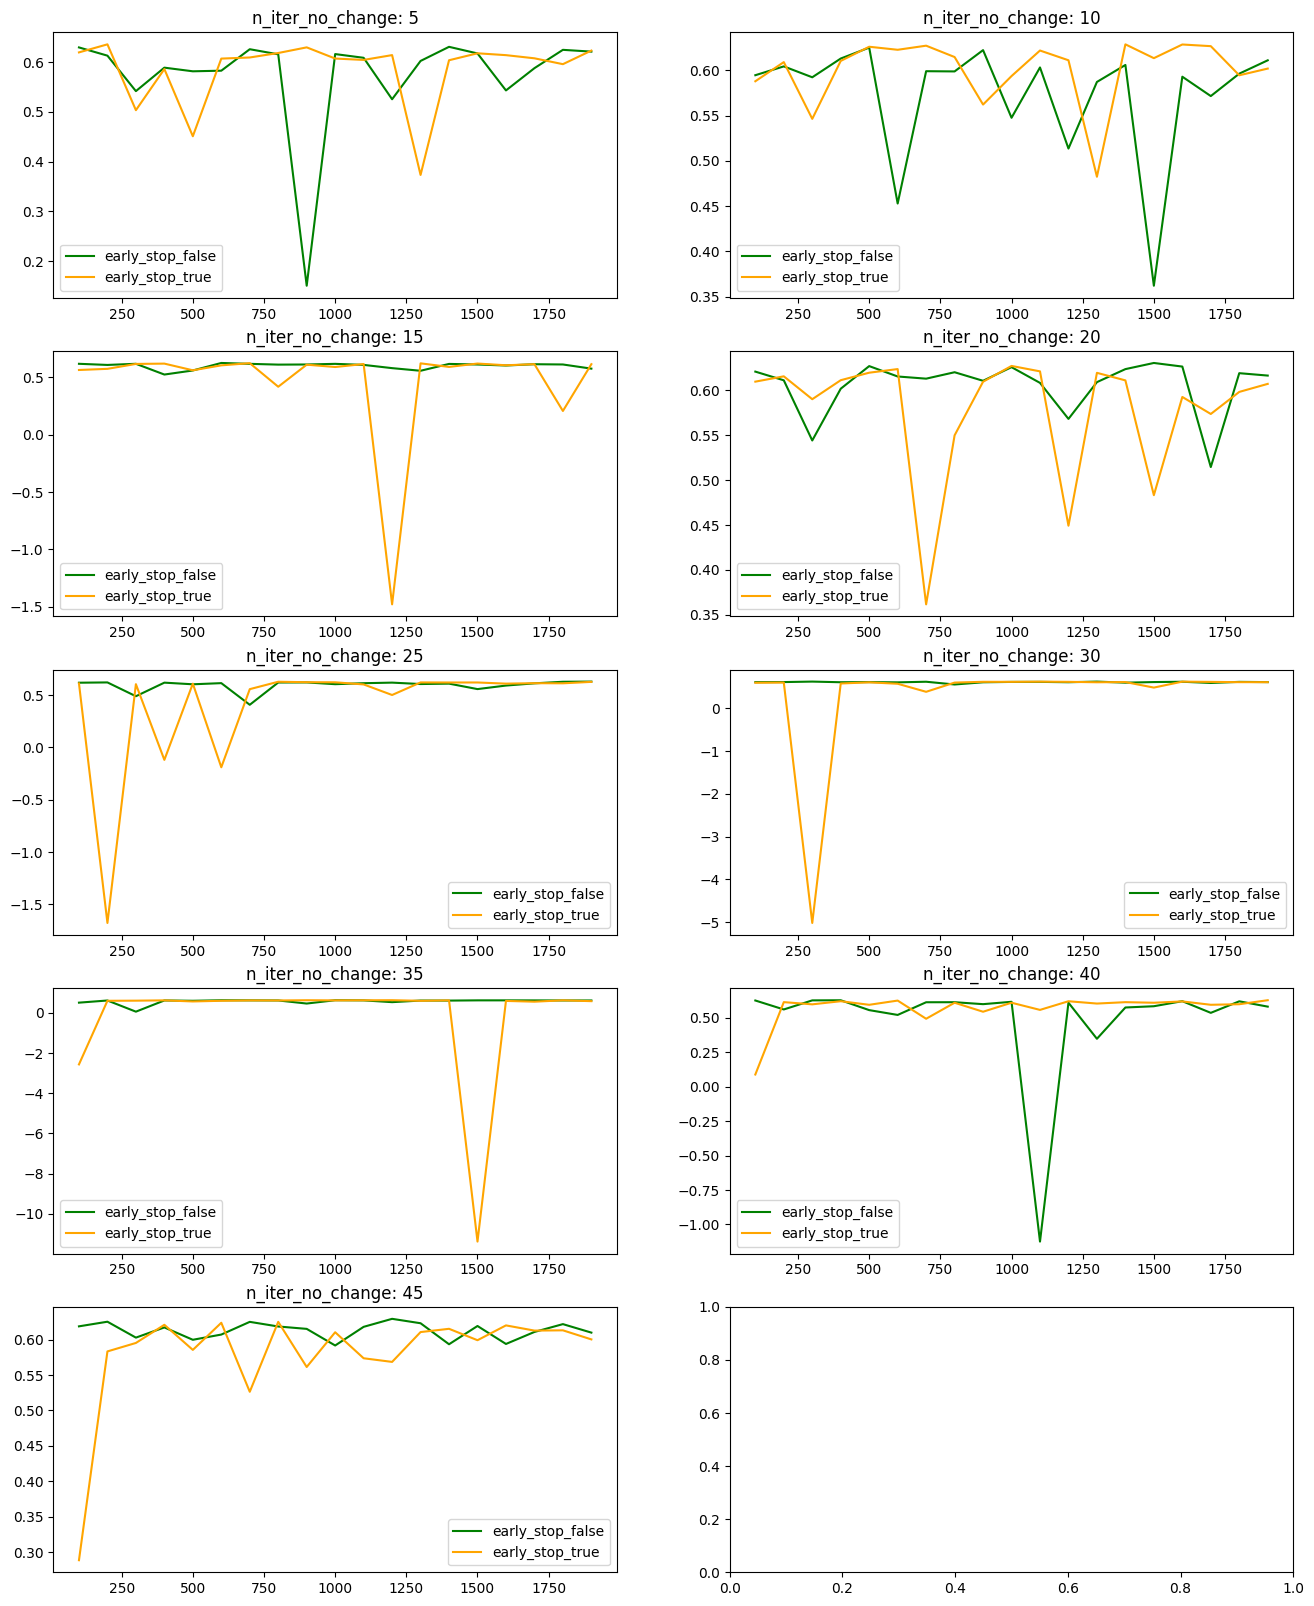

In [31]:
grid_search = GridSearchCV(
    sgd_red,
    param_grid={
        "max_iter":np.arange(100,2000,100),
        "early_stopping" : [False, True],
        "n_iter_no_change" : np.arange(5,50,5),
        "learning_rate":["constant"]
    },
    verbose=3,
    n_jobs=3
)

grid_search.fit(train_x, train_y)

grid_summary = pd.DataFrame({
    "score" : grid_search.cv_results_["mean_test_score"],
    "max_iter" : grid_search.cv_results_["param_max_iter"],
    "early_stopping" : grid_search.cv_results_["param_early_stopping"],
    "n_iter_no_change" : grid_search.cv_results_["param_n_iter_no_change"],
    # "learning_rate" : grid_search.cv_results_["params_learning_rate"]
})

n_groups_set = grid_summary.groupby("n_iter_no_change")

fig, ax = plt.subplots(figsize=(16,2*10), nrows=5, ncols=2)

axes = ax.flat

n_groups = grid_search.get_params()["param_grid"]["n_iter_no_change"]

for group in n_groups:
    groups = n_groups_set.get_group(group)
    early_stop = groups.groupby("early_stopping")
    ax = next(axes)
    ax.set_title(f"n_iter_no_change: {group}")
    ax.plot(early_stop.get_group(False)["max_iter"], early_stop.get_group(False)["score"], color="green", label="early_stop_false")
    ax.plot(early_stop.get_group(True)["max_iter"], early_stop.get_group(True)["score"], color="orange", label="early_stop_true")

    ax.legend()
plt.show()

In [32]:
grid_search.best_estimator_

SGDRegressor(early_stopping=True, learning_rate='constant', max_iter=200)

In [33]:
grid_search.best_score_

0.6357734681743084